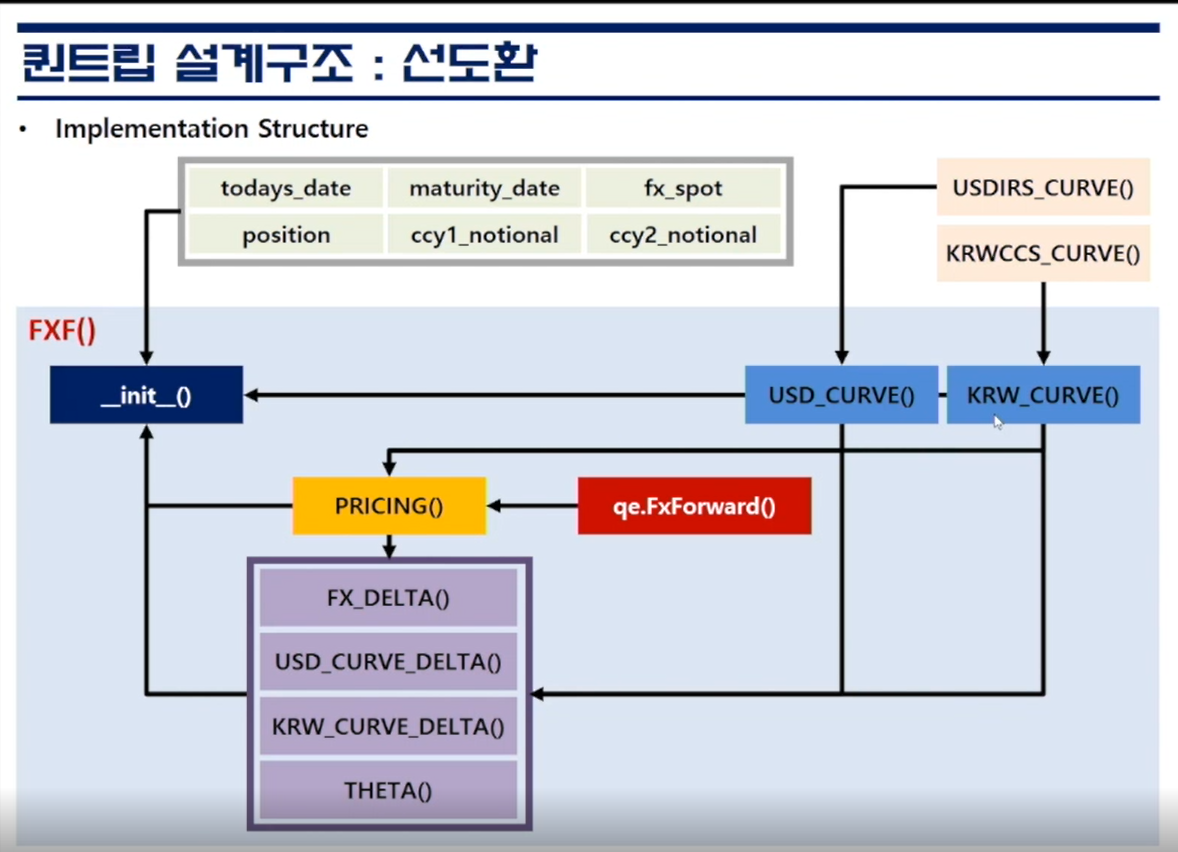

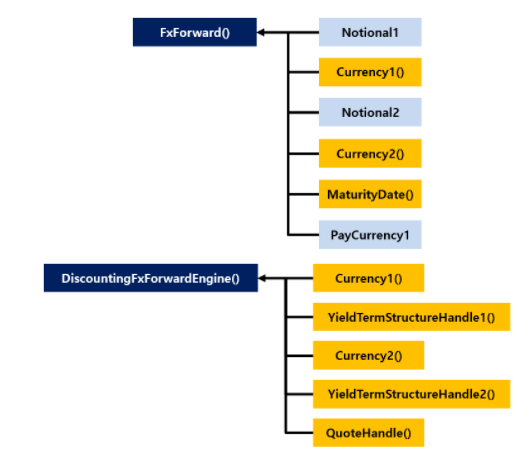

In [1]:
import datetime
import QuantExt as qe
from SWAP_CURVE_hb import GET_QUOTE, USDIRS_CURVE, KRWCCS_CURVE

In [2]:
class FXF():
    def __init__(self, todays_date, maturity_date, fx_spot, fx_forward, usd_notional, position):
        # date, curves, fx spot
        self.date = todays_date
        self.usd_curve = self.USD_CURVE(self.date)
        self.krw_curve = self.KRW_CURVE(self.date)
        self.fx_spot = fx_spot
        
        #instrument
        self.maturity_date = qe.Date(maturity_date.day, maturity_date.month, maturity_date.year)
        self.usd = qe.KRWCurrency()
        self.usd_notional = usd_notional
        self.krw = qe.USDCurrency()
        self.krw_notional = usd_notional * fx_forward #선도환율
        self.day_count = qe.ActualActual()
        
        if position == 'Long':
            # 원화를 내고 달러를 받는 선도환 매수
            self.payCcy1 = True
        else:
            self.payCcy1 = False
            
        self.npv = self.PRICING(self.usd_curve, self.krw_curve, self.fx_spot)
        self.fx_delta = self.FX_DELTA()
        self.usd_ir_delta = self.USD_IR_DELTA()
        self.krw_ir_delta = self.KRW_IR_DELTA()
        self.theta = self.THETA()
        
    def USD_CURVE(self, date):
        return USDIRS_CURVE(date, GET_QUOTE(date, 'USD'))
    
    def KRW_CURVE(self, date):
        return KRWCCS_CURVE(date, GET_QUOTE(date, 'KRW'))
    
    def PRICING(self, usd_curve, krw_curve, fx_spot):
        #market variable
        usd_curve_handle = qe.YieldTermStructureHandle(usd_curve)
        krw_curve_handle = qe.YieldTermStructureHandle(krw_curve)
        fx_spot_handle = qe.QuoteHandle(qe.SimpleQuote(fx_spot))
        
        fxf = qe.FxForward(self.krw_notional,
                          self.krw,
                          self.usd_notional,
                          self.usd,
                          self.maturity_date,
                          self.payCcy1)

        engine = qe.DiscountingFxForwardEngine(self.krw,
                                              krw_curve_handle,
                                              self.usd,
                                              usd_curve_handle,
                                              fx_spot_handle)

        fxf.setPricingEngine(engine)
        npv = fxf.NPV()
        return npv
    
    def FX_DELTA(self):
        # 1%
        percentage = 0.01
        
        # fx forward price when 1% up
        up_fx = self.fx_spot * (1 + percentage)
        up_fxf = self.PRICING(self.usd_curve, self.krw_curve, up_fx)
        
        # fx forward price when 1% down
        down_fx = self.fx_spot * (1 - percentage)
        down_fxf = self.PRICING(self.usd_curve, self.krw_curve, down_fx)
        
        fx_delta = (up_fxf - down_fxf) / 2
        return fx_delta
    
    def USD_IR_DELTA(self):
        # Handle of USD Curve
        curve_handle = qe.YieldTermStructureHandle(self.usd_curve)
        
        # 1bp
        basis_point = 0.0001
        
        # FX Forward price when 1bp up
        up_curve = qe.ZeroSpreadedTermStructure(curve_handle, qe.QuoteHandle(qe.SimpleQuote(basis_point)))
        up_fxf = self.PRICING(up_curve, self.krw_curve, self.fx_spot)
        
        # FX Forward price when 1bp down
        down_curve = qe.ZeroSpreadedTermStructure(curve_handle, qe.QuoteHandle(qe.SimpleQuote(-basis_point)))
        down_fxf = self.PRICING(down_curve, self.krw_curve, self.fx_spot)

        # USD Curve Delta
        delta = (up_fxf - down_fxf) / 2
        return delta
    
    def KRW_IR_DELTA(self):
        # Handle of KRW Curve
        curve_handle = qe.YieldTermStructureHandle(self.krw_curve)
        
        # 1bp
        basis_point = 0.0001
        
        # FX Forward price when 1bp up
        up_curve = qe.ZeroSpreadedTermStructure(curve_handle, qe.QuoteHandle(qe.SimpleQuote(basis_point)))
        up_fxf = self.PRICING(self.usd_curve, up_curve, self.fx_spot)
        
        # FX Forward price when 1bp down
        down_curve = qe.ZeroSpreadedTermStructure(curve_handle, qe.QuoteHandle(qe.SimpleQuote(-basis_point)))
        down_fxf = self.PRICING(self.usd_curve, down_curve, self.fx_spot)

        # KRW Curve Delta
        delta = (up_fxf - down_fxf) / 2
        return delta 
    
    def THETA(self):
        # FX Forward Price at T0
        price_t0 = self.PRICING(self.usd_curve, self.krw_curve, self.fx_spot)

        # FX Forward Price at T1
        usd_curve_t1 = self.USD_CURVE(self.date + datetime.timedelta(days=1))
        krw_curve_t1 = self.KRW_CURVE(self.date + datetime.timedelta(days=1))
        price_t1 = self.PRICING(usd_curve_t1, krw_curve_t1, self.fx_spot)
        
        # Theta
        theta = price_t1 - price_t0
        return theta
    
if __name__ == "__main__":
    
    # Today's Date
    todays_date = datetime.date(2020, 10, 9)
    
    # FX Spot Rate
    fx_spot = 1153.30
    
    # FX Forward Instrument
    fx_forward = 1152.32
    maturity_date = datetime.date(2021, 10, 9)
    usd_notional = 10000000
    krw_notional = usd_notional * fx_forward
    position = 'Long'
    
    # Build FXF Object
    fxf = FXF(todays_date,
              maturity_date,
              fx_spot,
              fx_forward,
              usd_notional,
              position)

    # Print the Results
    print("Price = {}".format(round(fxf.npv, 4)))
    print("FX Delta = {}".format(round(fxf.fx_delta, 4)))
    print("USD IR Delta = {}".format(round(fxf.usd_ir_delta, 4)))
    print("KRW IR Delta = {}".format(round(fxf.krw_ir_delta, 4)))
    print("Theta = {}".format(round(fxf.theta, 4)))

Price = -99085.9483
FX Delta = 115055468.771
USD IR Delta = -1166534.6159
KRW IR Delta = 1150564.5982
Theta = -48395.1475
